# Natural Language Processing - Bill Text Exploration


Transform the raw data into feature vectors and these new features will be created using the existing dataset. Structure as follows:

Data Exploration
- Word Cloud 

Vectorizers
- Custom and Spacy Tokenizer
- Count Vectors as features
- TF-IDF Vectors as features

- Word level
- N-Gram level

Character level
- Word Embeddings as features
- Text / NLP based features
- Topic Models as features

https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/

In [342]:
import mysql.connector 
import numpy as np
import pandas as pd
import config_final
import requests

from sodapy import Socrata
import sqlalchemy as db


In [343]:
def query(q):
    try:
        return pd.read_sql_query(q, engine)
    # Pass when no data is returned    
    except ResourceClosedError:
        pass

def query_list(col, table, distinct = True):
    elts = ['SELECT',
            'DISTINCT' if distinct else '',
            col,
            'FROM',
            table]
    query_str = ' '.join(elts)
    df = query(query_str)
    l = df.iloc[:,0].tolist()
    return l

In [344]:
engine = db.create_engine(f'mysql+mysqlconnector://{config_final.user}:{config_final.password}@{config_final.host}/con_bills')

connection = engine.connect()
metadata=db.MetaData()

In [345]:
df = query('SELECT BillID, Title, Summary, PassH, Cong FROM con_bills.current_bills')


In [346]:
df.tail()

,BillID,Title,Summary,PassH,Cong
34285,114-S-995,A bill to establish congressional trade negoti...,Bipartisan Congressional Trade Priorities and ...,0,114
34286,114-S-996,A bill to facilitate nationwide availability o...,Volunteer Income Tax Assistance (VITA) Act,0,114
34287,114-S-997,A bill to extend the authorization for the maj...,"Department of Veterans Affairs Construction, A...",0,114
34288,114-S-998,A bill to establish a process for the consider...,American Manufacturing Competitiveness Act of ...,0,114
34289,114-S-999,A bill to amend the Small Business Act to prov...,Small Business Development Centers Improvement...,0,114


In [347]:
df['Summary'].isnull().sum()

34

In [348]:
df['PassH'].value_counts()

0    31997
1     2293
Name: PassH, dtype: int64

In [349]:
blanks = []

for i, billID, title, summary, PassH, Cong in df.itertuples():  # iterate over the DataFrame
    if type(summary)==str:            # avoid NaN values
        if summary.isspace():         # test 'plot' for whitespace
            blanks.append(i)
                  
len(blanks)

0

# Wordcloud Exploration

Initial exploration of topics in dependent variable using wordcloud and stopword engineering.

Pass House 0 = Bills did not pass House

Pass House 1 = Bill passed House


In [350]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)
stopwords.add("concurrent")
stopwords.add("resolution")
stopwords.add("recognizing")
stopwords.add("providing")
stopwords.add("provide")
stopwords.add("bill")
stopwords.add("congressional")
stopwords.add("authorizing")
stopwords.add("authorize")
stopwords.add("designating")
stopwords.add("designate")
stopwords.add("printi")
stopwords.add("printing")
stopwords.add("printed")
stopwords.add("Congress")
stopwords.add("Authorizes")
stopwords.add("Provides")

In [351]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords, 
        max_words=50,
        max_font_size=40, 
        scale=3,
        random_state=1 
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()


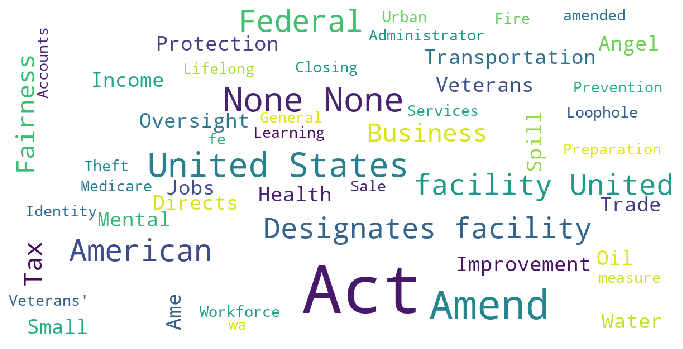

In [352]:
show_wordcloud(df[df['PassH']==0]['Summary'])

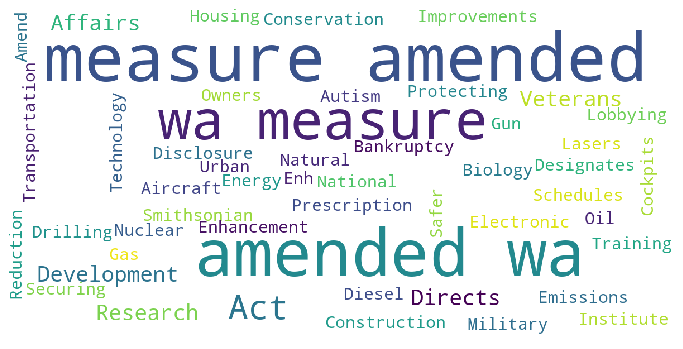

In [353]:
show_wordcloud(df[df['PassH']==1]['Summary'])

In [354]:
#Wordcloud on difference of frequencies

# Topic Modeling

**Split Training and Testing Data**

In [355]:
from sklearn import preprocessing

In [356]:
from sklearn.model_selection import train_test_split

X = df['Title']
y = df['PassH']

X_train, X_test, y_train1, y_test1 = train_test_split(X, y, )

In [357]:
X_test

8200     To suspend temporarily the duty on Acid Yellow...
15029    A bill to support State and tribal government ...
21346    A bill to amend the Internal Revenue Code of 1...
28319    To provide for increased Federal oversight of ...
24547    To amend title 49, United States Code, to proh...
31992    A bill to increase the worldwide level of empl...
12636    A bill to establish an integrated Federal prog...
14888    A bill to designate the Valles Caldera Nationa...
31520    A bill to designate certain land administered ...
172      Making supplemental appropriations for the Uni...
20078    To amend the Tariff Act of 1930 to eliminate t...
29671    To amend the Occupational Safety and Health Ac...
30354    To amend section 552 of title 5, United States...
19944    To promote unlicensed spectrum use in the 5 GH...
5606     To reduce Federal spending in a responsible ma...
14587    A bill to establish an Office of Entrepreneuri...
28438    To increase the participation of historically .

In [358]:
df['PassH'].head()

0    0
1    0
2    0
3    0
4    0
Name: PassH, dtype: int64

Encode our target column so that it can be used in machine learning models (may not be necessary since the data is already binary)

In [359]:
encoder = preprocessing.LabelEncoder()

y_train = encoder.fit_transform(y_train1)
y_test = encoder.fit_transform(y_test1)

In [360]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

## Feature Engineering


**Cleaning Text**

Test both the spacy tokenizer and personalized tokenizer against the data.

In [361]:
import spacy
from spacy.lang.en import English
# For part of speech tagging
import en_core_web_sm

nlp = English()
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [362]:
#Editing the stopwords list
# spacy_stopwords.add('concurrent', 'resolution')

In [363]:
#Lemmitization

# for word in lem:
#     print(word.text, word.lemma_)

NameError: name 'lem' is not defined

In [364]:
#Part of speech tagging
nlp_pos = en_core_web_sm.load()


In [365]:
#Define the spacy tokenizer
spacy_tokenizer = spacy.load('en_core_web_sm', disable =['tagger', 'parser', 'ner'])

In [366]:
import string
import re

replace_with_space = re.compile('[/(){}\[\]\|@,;]')

just_words = re.compile('[^a-zA-Z\s]')


<>:4: DeprecationWarning: invalid escape sequence \[
<>:6: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \[
<>:6: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \[
<>:6: DeprecationWarning: invalid escape sequence \s
<ipython-input-366-983721234798>:4: DeprecationWarning: invalid escape sequence \[
  replace_with_space = re.compile('[/(){}\[\]\|@,;]')
<ipython-input-366-983721234798>:6: DeprecationWarning: invalid escape sequence \s
  just_words = re.compile('[^a-zA-Z\s]')


In [367]:
from spacy.lemmatizer import Lemmatizer
from spacy.lookups import Lookups
lemmatizer = Lemmatizer(lookups)

In [368]:
# stopwords = set(STOPWORDS)

In [369]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

def tokenizer(text):
    
    #lowercase everything
    lower_text = text.lower()
    
    #remove punctuation
#     no_pun_text = lower_text.translate(str.maketrans('', '', string.punctuation))
    
    #get rid of weird characters
    text = replace_with_space.sub('',lower_text)
    
    #remove numbers
    just_words_text = just_words.sub('', text)
    
    #add spacy tokenizer
    mytokens = nlp(just_words_text, disable=['parser', 'ner'])
#     print(mytokens)
    
    #for POS tagging
#     mytokens = [word for word in mytokens if (word.pos_ == 'NOUN') or (word.pos_ == 'VERB') or (word.pos_ == 'ADJ') or (word.pos_ == 'ADV')]
    
    #lemmatize
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    #add stopwords
    mytokens = [word for word in mytokens if word not in spacy_stopwords and word not in punctuations]
    
    return mytokens
    

In [370]:
test_fun = df.iloc[5559][2]
test_fun

'New Philadelphia, Illinois, Study Act - Directs the Secretary of the Interior to conduct a special resource study of the New Philadelphia archaeological site and the land surrounding it in Illinois (the study area).'

In [371]:
tokenizer(test_fun)


['new',
 'philadelphia',
 'illinois',
 'study',
 'act',
 'direct',
 'secretary',
 'interior',
 'conduct',
 'special',
 'resource',
 'study',
 'new',
 'philadelphia',
 'archaeological',
 'site',
 'land',
 'surround',
 'illinois',
 'study',
 'area']

**Saving to DF**

In [372]:
# df['clean_summaries'] = df.apply(lambda row: clean(row['Summary']), axis=1)

In [373]:
# df['tokenized_summaries'] = df.apply(lambda row: tokenizer(row['Summary']), axis=1)


In [374]:
df.shape

(34290, 5)

In [375]:
df[:34290]

,BillID,Title,Summary,PassH,Cong
0,111-HR-10,Reserved for the Speaker.,None,0,111
1,111-HR-1135,"To amend title 49, United States Code, to prov...",None,0,111
2,111-HR-3,Reserved for the Speaker.,None,0,111
3,111-HR-4,Reserved for the Speaker.,None,0,111
4,111-HR-5,Reserved for the Speaker.,None,0,111
5,111-HR-535,To amend title 44 of the United States Code to...,None,0,111
6,111-HR-5708,To amend the Workforce Investment Act of 1998 ...,Urban Jobs Act of 2010 - Amends the Workforce ...,0,111
7,111-HR-5709,To amend the Outer Continental Shelf Lands Act...,Oil Spill Preparation and Protection Act - Ame...,0,111
8,111-HR-5710,To amend and reauthorize the controlled substa...,National All Schedules Prescription Electronic...,1,111
9,111-HR-5711,To provide for the furnishing of statues by th...,(This measure has not been amended since it wa...,0,111


**CountVectorizer**

Every row represents a document in the corpus, every column represents a term in the document, every cell represents the frequency count of a particular term in a particular document.

Tuning: analyzer, vectorizer, max_features, max_df, min_df, n_grams

In [376]:
#decide if i want to use these

# params = {'vect__max_df': (0.5, 0.75, 1.0),
#         'vect__max_features': (None, 5000, 10000, 50000),
#         'vect__ngram_range': ((1, 1), (1, 2))
#          }

In [377]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer = tokenizer)
transformed = vectorizer.fit_transform(X_train, y_train)
print(len(vectorizer.get_feature_names()))

12429


In [378]:
X_train.head()

19567    To amend the Bank Holding Company Act of 1956 ...
11406    To enhance penalties for violations of securit...
23415    A bill to prevent nuclear proliferation in Nor...
27064    To amend the section 484(r) of the Higher Educ...
19987    To establish a grant program in the Department...
Name: Title, dtype: object

In [379]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [380]:
# fit and transform training data

# dtm_train_cv = cv.fit_transform(X_train)
# dtm_test_cv = cv.transform(X_test)

**Exploring Stored Words**

Think about the number of words and how to decrease that list!

Lemmatization should be something to further consider, also limiting specific words (pronouns?) used often

In [381]:
# print(vectorizer.get_feature_names())

In [382]:
len(vectorizer.get_feature_names())

12429

In [383]:
import random

#get ten random words from each

for i in range(10):
    word_id = random.randint(0, 9959) #second should be len of cv
    print(vectorizer.get_feature_names()[word_id])

dna
dioxide
kelley
liquidate
acetylamino
noxoimidazolidineylethylmethylacrylamide
outerwear
fallen
northeastern
credibility


**Topic - Modeling LDA**


LDA is an iterative model which starts from a fixed number of topics. Each topic is represented as a distribution over words, and each document is then represented as a distribution over topics.

In [384]:
from sklearn.decomposition import LatentDirichletAllocation

In [385]:
# Build LDA Model
#focus on number topics, max iteration, learning decay

# lda_model = LatentDirichletAllocation(n_components=15,               # Number of topics
#                                       max_iter=20,  
#                                       learning_decay=0.5,    # Max learning iterations (how many times going over whole dataset)
# #                                       learning_method='online',   #constantly update with new data or batch
#                                       random_state=42,          # Random state
#                                       batch_size=128,            # n docs in each learning iter
#                                       evaluate_every = -1,       # compute perplexity every n iters, default: Don't
#                                       n_jobs = -1,               # Use all available CPUs
#                                      )

# print(lda_model)  # Model attributes

In [386]:
# This can take awhile, we're dealing with a large amount of documents!

# lda_output = lda_model.fit_transform(transformed)


**OPTIONAL - Grisearch LDA**

In [387]:
from sklearn.model_selection import GridSearchCV


# Define Search Param
search_params = {'n_components': [10, 12, 15],
                 'learning_decay': [.3, .4, .5]
                }

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params, cv=3, verbose=2, n_jobs = -1)

# Do the Grid Search
model.fit(transformed)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 12.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 total_s

In [388]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(transformed))

#Shows best params
#shows best log likelihood
#shows model perplexity score

Best Model's Params:  {'learning_decay': 0.3, 'n_components': 10}
Best Log Likelihood Score:  -925062.6312612939
Model Perplexity:  918.3010429565078


**Gridsearch 1**: 
- Best Model's Params:  {'learning_decay': 0.5, 'n_components': 15}
- Best Log Likelihood Score:  -751642.0137549518
- Model Perplexity:  921.196053929341

**Gridseach 2**:
-

- Best Model's Params:  {'learning_decay': 0.3, 'n_components': 10}
- Best Log Likelihood Score:  -925062.6312612939
- Model Perplexity:  918.3010429565078

**Model evaluation:**

In [275]:
# # Log Likelyhood: Higher the better
# print("Log Likelihood: ", lda_model.score(transformed))

# # Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
# print("Perplexity: ", lda_model.perplexity(transformed))

# # See model parameters
# print(lda_model.get_params())

Log Likelihood:  -2023593.7189975688
Perplexity:  918.4023644801994
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.5, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 20, 'mean_change_tol': 0.001, 'n_components': 15, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 42, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


Look at model components:

In [389]:
best_lda_model.components_

array([[0.1       , 1.09985763, 0.1       , ..., 3.09997447, 1.09990892,
        0.1       ],
       [0.1       , 0.1       , 0.1       , ..., 0.1       , 0.1       ,
        0.1       ],
       [0.1       , 0.1       , 0.1       , ..., 0.10001357, 0.1       ,
        0.1       ],
       ...,
       [1.09941287, 0.1       , 0.1       , ..., 0.1       , 0.1       ,
        0.1       ],
       [0.10023616, 0.1       , 0.1       , ..., 0.1       , 0.1       ,
        0.1       ],
       [0.1       , 0.1       , 2.1       , ..., 0.10001195, 0.1       ,
        0.1       ]])

In [390]:
single_topic = best_lda_model.components_[0]

In [391]:
# Returns the indices that would sort this array.
single_topic.argsort()

#look at the most and least representative words!

array([ 2727,  3845, 11506, ...,   134, 10252,  5057])

In [392]:
# Word least representative of this topic
single_topic[248]

#first round goes from 0.05 to 106.1

0.10000000160050686

In [393]:
# Word most representative of this topic
single_topic[8108]

0.10000467896204046

Look at the top fifteen for each topic:

In [394]:
for index,topic in enumerate(best_lda_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

#print top fifteen words for each topic
#increase number of topics to get more specific topics
#go back and clean some of the data based on answers

THE TOP 15 WORDS FOR TOPIC #0
['public', 'purpose', 'xviii', 'provide', 'bill', 'medicare', 'care', 'program', 'title', 'amend', 'security', 'social', 'act', 'service', 'health']


THE TOP 15 WORDS FOR TOPIC #1
['compensation', 'act', 'oil', 'gas', 'affair', 'prohibit', 'veteran', 'department', 'certain', 'secretary', 'water', 'federal', 'veterans', 'bill', 'purpose']


THE TOP 15 WORDS FOR TOPIC #2
['authorize', 'high', 'school', 'development', 'secretary', 'energy', 'establish', 'grant', 'provide', 'amend', 'act', 'education', 'program', 'bill', 'purpose']


THE TOP 15 WORDS FOR TOPIC #3
['disclosure', 'exchange', 'provision', 'control', 'financial', 'insurance', 'require', 'extend', 'protection', 'consumer', 'certain', 'amend', 'purpose', 'bill', 'act']


THE TOP 15 WORDS FOR TOPIC #4
['mixture', 'reduce', 'rate', 'acid', 'member', 'armed', 'force', 'certain', 'suspension', 'temporary', 'extend', 'suspend', 'bill', 'temporarily', 'duty']


THE TOP 15 WORDS FOR TOPIC #5
['care', 'pro

In [396]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(transformed)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)] #change to best_lda_model after gridsearch!

# index names
docnames = ["Doc" + str(i) for i in range(len(X_train))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

#final column shows the topic each document is most 'like'
#topcis are distribution of words, and see which scores most highly on, and applying that topic to the document

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.01,0.01,0.01,0.01,0.01,0.92,0.01,0.01,0.01,0.01,5
Doc1,0.01,0.01,0.01,0.44,0.01,0.01,0.47,0.01,0.01,0.01,6
Doc2,0.01,0.01,0.01,0.01,0.01,0.01,0.43,0.01,0.01,0.47,9
Doc3,0,0,0.54,0,0.12,0,0,0,0.31,0,2
Doc4,0.01,0.01,0.85,0.01,0.01,0.01,0.01,0.01,0.1,0.01,2
Doc5,0.58,0.01,0.01,0.01,0.01,0.01,0.37,0.01,0.01,0.01,0
Doc6,0,0,0,0,0,0,0,0.06,0,0.91,9
Doc7,0.02,0.02,0.02,0.02,0.02,0.82,0.02,0.02,0.02,0.02,5
Doc8,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.91,9
Doc9,0,0,0,0,0,0,0.39,0,0.38,0.21,6


In [283]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,11,2356
1,10,2280
2,1,1695
3,13,1616
4,9,1454
5,5,1358
6,14,1342
7,12,1266
8,8,1266
9,7,1078


In [397]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in best_lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,health,service,act,social,security,amend,title,program,care,medicare,bill,provide,xviii,purpose,public
Topic 1,purpose,bill,veterans,federal,water,secretary,certain,department,veteran,prohibit,affair,gas,oil,act,compensation
Topic 2,purpose,bill,program,education,act,amend,provide,grant,establish,energy,secretary,development,school,high,authorize
Topic 3,act,bill,purpose,amend,certain,consumer,protection,extend,require,insurance,financial,control,provision,exchange,disclosure
Topic 4,duty,temporarily,bill,suspend,extend,temporary,suspension,certain,force,armed,member,acid,rate,reduce,mixture
Topic 5,act,amend,purpose,bill,federal,provide,business,small,child,assistance,program,drug,food,protection,care
Topic 6,purpose,bill,security,require,federal,provide,act,information,secretary,amend,establish,homeland,congress,report,program
Topic 7,amend,revenue,code,internal,tax,bill,purpose,credit,provide,income,certain,extend,allow,property,increase
Topic 8,united,states,title,code,amend,purpose,bill,provide,certain,veteran,veterans,federal,law,secretary,assistance
Topic 9,purpose,national,bill,state,land,year,provide,certain,federal,fiscal,authorize,appropriation,secretary,department,management


**Dominant topic visualizations**



Topic models only:

In [398]:
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [399]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, transformed, vectorizer, mds='tsne')
panel

/Users/melissamunz/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2      32.420952   8.115230       1        1  13.693875
8       0.648955  71.707100       2        1  12.767929
5      71.019684   9.971006       3        1  12.107080
9       3.785981  33.185135       4        1  11.115844
6     -42.666500  -9.222070       5        1  10.974640
0      -3.621689 -43.526516       6        1  10.525906
7      -3.632402  -4.171708       7        1  10.002887
1     -36.584400  35.804413       8        1   7.168439
3      44.391380  50.615383       9        1   6.231734
4      40.235809 -31.591665      10        1   5.411666, topic_info=      Category          Freq         Term         Total  loglift  logprob
11789  Default   4649.000000       united   4649.000000  30.0000  30.0000
10729  Default   4575.000000       states   4575.000000  29.0000  29.0000
3560   Default   2395.000000         duty   2395.000000  28.0000  28.0000
2073   Default   4280.000000         code   4280.000000  27.0000  27.0000
9774   Default   2271.000000      revenue   2271.000000  26.0000  26.0000
11383  Default   3512.000000        title   3512.000000  25.0000  25.0000
5784   Default   2198.000000     internal   2198.000000  24.0000  24.0000
5057   Default   2289.000000       health   2289.000000  23.0000  23.0000
11196  Default   1382.000000  temporarily   1382.000000  22.0000  22.0000
134    Default   7568.000000          act   7568.000000  21.0000  21.0000
11032  Default   1222.000000      suspend   1222.000000  20.0000  20.0000
4122   Default   1777.000000       extend   1777.000000  19.0000  19.0000
10160  Default   2404.000000     security   2404.000000  18.0000  18.0000
446    Default   9788.000000        amend   9788.000000  17.0000  17.0000
10523  Default   1356.000000       social   1356.000000  16.0000  16.0000
3626   Default   1415.000000    education   1415.000000  15.0000  15.0000
11197  Default    921.000000    temporary    921.000000  14.0000  14.0000
11127  Default   1073.000000          tax   1073.000000  13.0000  13.0000
11033  Default    859.000000   suspension    859.000000  12.0000  12.0000
10252  Default   2844.000000      service   2844.000000  11.0000  11.0000
8981   Default   3671.000000      program   3671.000000  10.0000  10.0000
1625   Default   1367.000000         care   1367.000000   9.0000   9.0000
1156   Default  10511.000000         bill  10511.000000   8.0000   8.0000
2623   Default    978.000000       credit    978.000000   7.0000   7.0000
6862   Default    816.000000     medicare    816.000000   6.0000   6.0000
6198   Default    939.000000         land    939.000000   5.0000   5.0000
7416   Default   2299.000000     national   2299.000000   4.0000   4.0000
11989  Default    901.000000     veterans    901.000000   3.0000   3.0000
1758   Default   4116.000000      certain   4116.000000   2.0000   2.0000
4499   Default    576.000000        force    576.000000   1.0000   1.0000
...        ...           ...          ...           ...      ...      ...
1263   Topic10     35.812249         blue     36.686953   2.8925  -6.3406
4330   Topic10     34.846992     filament     35.721663   2.8918  -6.3680
8106   Topic10     33.881688        oxide     34.756372   2.8911  -6.3961
6292   Topic10     30.985831      leather     31.860500   2.8888  -6.4854
8149   Topic10     30.985830         pair     31.860500   2.8888  -6.4854
11033  Topic10    834.804165   suspension    859.353749   2.8876  -3.1917
3340   Topic10     29.055249     disperse     29.929918   2.8870  -6.5497
4782   Topic10     29.042753         girl     29.929843   2.8865  -6.5502
2472   Topic10     28.089958    copolymer     28.964627   2.8860  -6.5835
8479   Topic10     28.089957    phosphate     28.964627   2.8859  -6.5835
9285   Topic10     27.124669     reactive     27.999337   2.8849  -6.6185
11197  Topic10    861.374055    temporary    921.842533   2.8488  -3.1604
4315   Topic10     98.730497 

Visualization using clustering:

In [401]:
# Construct the k-means clusters
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.23  0.16  0.55  0.14  0.17  0.38  0.31  0.28  0.37  0.34]
 [-0.12 -0.03  0.79 -0.05 -0.09 -0.37 -0.17 -0.28 -0.33  0.05]]
Perc of Variance Explained: 
 [0.02 0.14]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

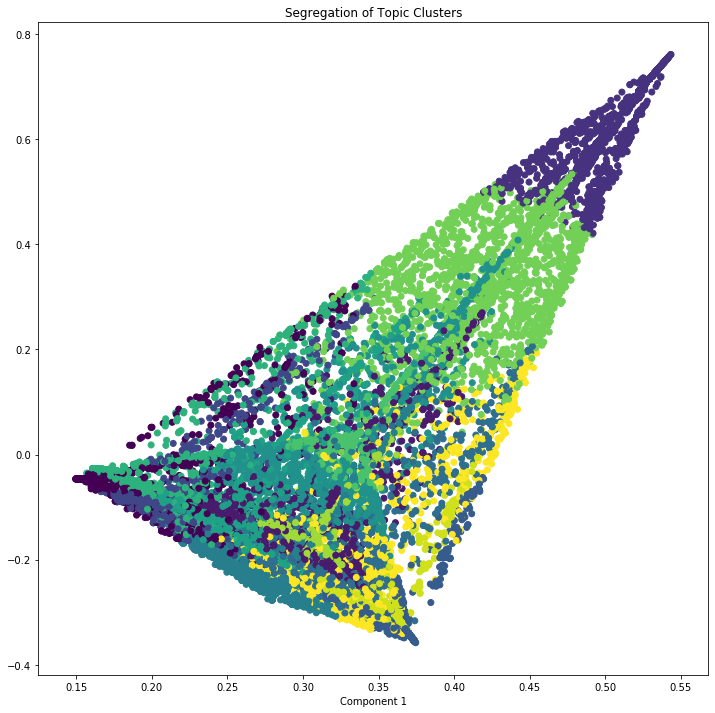

In [402]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [ ]:
#find out how to make in 3D

**Predict a Topic**

In [ ]:
# Define function to predict topic for a given text document.

# nlp = spacy.load('en', disable=['parser', 'ner'])

# def predict_topic(text, nlp=nlp):
#     global sent_to_words
#     global lemmatization

#     # Step 1: Clean with simple_preprocess
#     mytext_2 = list(sent_to_words(text))

#     # Step 2: Lemmatize
#     mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#     # Step 3: Vectorize transform
#     mytext_4 = vectorizer.transform(mytext_3)

#     # Step 4: LDA Transform
#     topic_probability_scores = best_lda_model.transform(mytext_4)
#     topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
#     return topic, topic_probability_scores

# # Predict the topic
# mytext = ["Some text about christianity and bible"]
# topic, prob_scores = predict_topic(text = mytext)
# print(topic)

Other Visualization Examples:
    
https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

**Data Mapper Pipeline**


This allow each column to be mapped to different encoders.

https://pypi.org/project/dataframe-mapper/

In [27]:
!pip install dataframe-mapper

Should do this for title and summary separately:

In [ ]:
column_tuples = [
    ('Sales', None),
    ('ShelveLoc', LabelEncoder()),
    ('Urban', LabelEncoder()), 
    ('US', LabelEncoder())]

mapper = DataFrameMapper(column_tuples, default=StandardScaler())
mapper_fit = mapper.fit(train)

# TFIDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_vectorizer = TfidfVectorizer(tokenizer = tokenizer)
tf_transformed = vectorizer.fit_transform(X_train, y_train)
print(len(tf_vectorizer.get_feature_names()))

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
transformed = vectorizer.fit_transform(X)
print "Num words:", len(vectorizer.get_feature_names())